<a href="https://colab.research.google.com/github/fansha1994/space-missions/blob/master/notebooks/Unit_2_Build_Week.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

In [2]:
import pandas as pd
%matplotlib inline
from category_encoders import OneHotEncoder, OrdinalEncoder
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, classification_report

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
space = pd.read_csv('https://raw.githubusercontent.com/fansha1994/space-missions/master/notebooks/datasets_828921_1417131_Space_Corrected.csv')
print(space.shape)
space.head()

(4324, 9)


,Unnamed: 0,Unnamed: 0.1,Company Name,Location,Datum,Detail,Status Rocket,Rocket,Status Mission
0,0,0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA","Fri Aug 07, 2020 05:12 UTC",Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.0,Success
1,1,1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...","Thu Aug 06, 2020 04:01 UTC",Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.75,Success
2,2,2,SpaceX,"Pad A, Boca Chica, Texas, USA","Tue Aug 04, 2020 23:57 UTC",Starship Prototype | 150 Meter Hop,StatusActive,NaN,Success
3,3,3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan","Thu Jul 30, 2020 21:25 UTC",Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65.0,Success
4,4,4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA","Thu Jul 30, 2020 11:50 UTC",Atlas V 541 | Perseverance,StatusActive,145.0,Success


In [4]:
space.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Company Name', 'Location', 'Datum',
       'Detail', 'Status Rocket', ' Rocket', 'Status Mission'],
      dtype='object')

# Wrangle Data


In [5]:
space = space.drop(['Unnamed: 0', 'Unnamed: 0.1', ' Rocket'], axis=1)
print(space.shape)
space.head()

(4324, 6)


,Company Name,Location,Datum,Detail,Status Rocket,Status Mission
0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA","Fri Aug 07, 2020 05:12 UTC",Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,Success
1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...","Thu Aug 06, 2020 04:01 UTC",Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,Success
2,SpaceX,"Pad A, Boca Chica, Texas, USA","Tue Aug 04, 2020 23:57 UTC",Starship Prototype | 150 Meter Hop,StatusActive,Success
3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan","Thu Jul 30, 2020 21:25 UTC",Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,Success
4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA","Thu Jul 30, 2020 11:50 UTC",Atlas V 541 | Perseverance,StatusActive,Success


In [6]:
space.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4324 entries, 0 to 4323
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Company Name    4324 non-null   object
 1   Location        4324 non-null   object
 2   Datum           4324 non-null   object
 3   Detail          4324 non-null   object
 4   Status Rocket   4324 non-null   object
 5   Status Mission  4324 non-null   object
dtypes: object(6)
memory usage: 202.8+ KB


In [7]:
# this is a classifation problem 
space['Status Mission'].value_counts()

Success              3879
Failure               339
Partial Failure       102
Prelaunch Failure       4
Name: Status Mission, dtype: int64

In [8]:
# first let's make it a binary classifcation 

space = space.replace({'Status Mission': {'Success': 1, 'Failure' : 0, 'Partial Failure' : 0, 'Prelaunch Failure': 0}})

In [9]:
space['Status Mission'].value_counts()

1    3879
0     445
Name: Status Mission, dtype: int64

In [10]:
# to stip the year month and day from Datum column, i have to change it to 
# datetime type 
space['Datum'] = pd.to_datetime(space['Datum'], utc=True)

In [11]:
space['Datum'].dtype

datetime64[ns, UTC]

In [12]:
# now let's add copule features to the dataset 
# we gonna need month day and year columns 

space['Launch Site'] = space['Location'].str.split(', ').str[1]
space['Country'] = space['Location'].str.split(', ').str[-1]
space['Mission Year'] = space['Datum'].dt.year
space['Mission Month'] = space['Datum'].dt.month
space['Mission Day'] = space['Datum'].dt.day
space.head()

,Company Name,Location,Datum,Detail,Status Rocket,Status Mission,Launch Site,Country,Mission Year,Mission Month,Mission Day
0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA",2020-08-07 05:12:00+00:00,Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,1,Kennedy Space Center,USA,2020,8,7
1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...",2020-08-06 04:01:00+00:00,Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,1,Jiuquan Satellite Launch Center,China,2020,8,6
2,SpaceX,"Pad A, Boca Chica, Texas, USA",2020-08-04 23:57:00+00:00,Starship Prototype | 150 Meter Hop,StatusActive,1,Boca Chica,USA,2020,8,4
3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan",2020-07-30 21:25:00+00:00,Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,1,Baikonur Cosmodrome,Kazakhstan,2020,7,30
4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA",2020-07-30 11:50:00+00:00,Atlas V 541 | Perseverance,StatusActive,1,Cape Canaveral AFS,USA,2020,7,30


In [13]:
# lets make the year column as index for this dateset so we can do time split 
space = space.set_index('Mission Year')

# Visualization

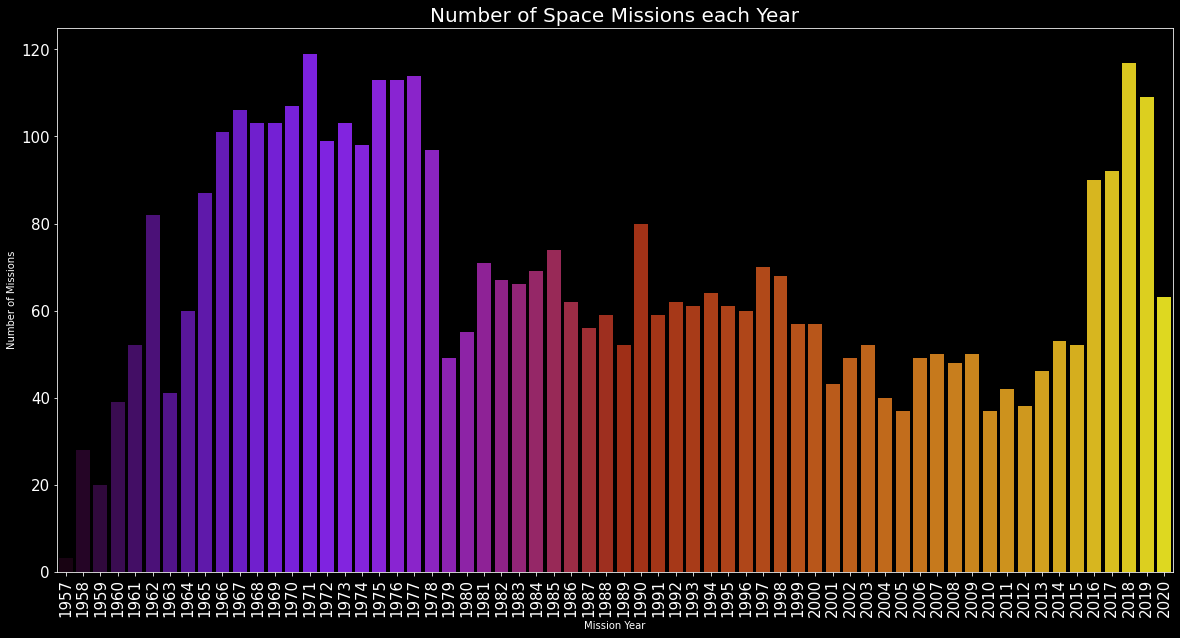

In [14]:
# first lets look at the years compere to the space flights 
# Get total match in each season

plt.rcParams['figure.figsize'] = (20,10)
plt.style.use('dark_background')

sns.countplot(space.index, palette = 'gnuplot')

plt.tick_params(labelsize=15) 
plt.title('Number of Space Missions each Year', fontweight = 30, fontsize =20)
plt.xticks(rotation = 90)
plt.ylabel('Number of Missions')
plt.show()

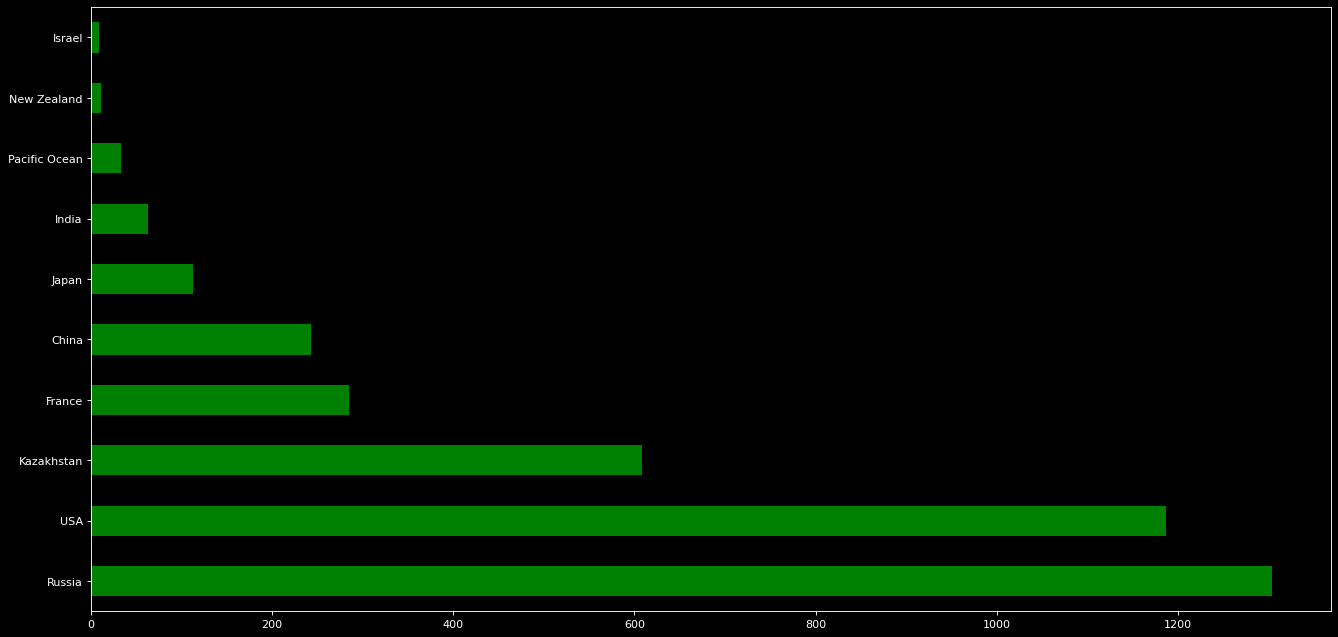

In [52]:
# successful flight per country 

Success = space[space['Status Mission']== 1]
Success['Country'].value_counts()[:10].plot(kind='barh',color='green');

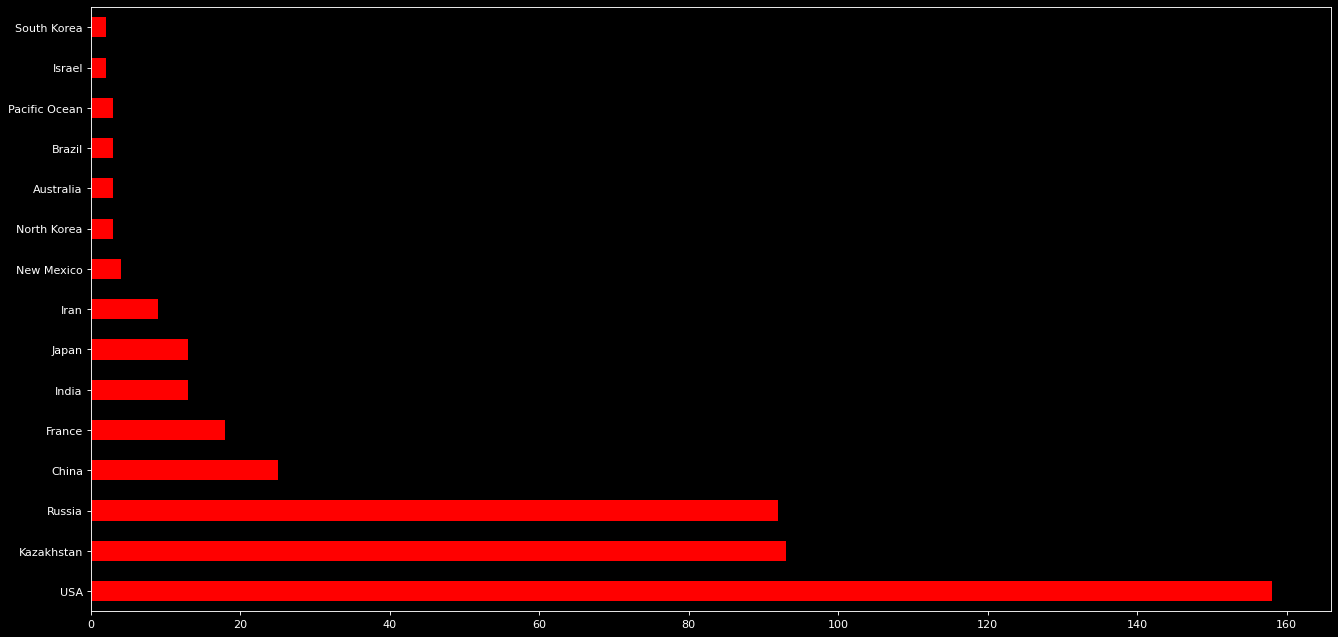

In [53]:
#failure flights per country 

Failure= space[space['Status Mission'] == 0]
Failure['Country'].value_counts()[:15].plot(kind='barh',color='red');

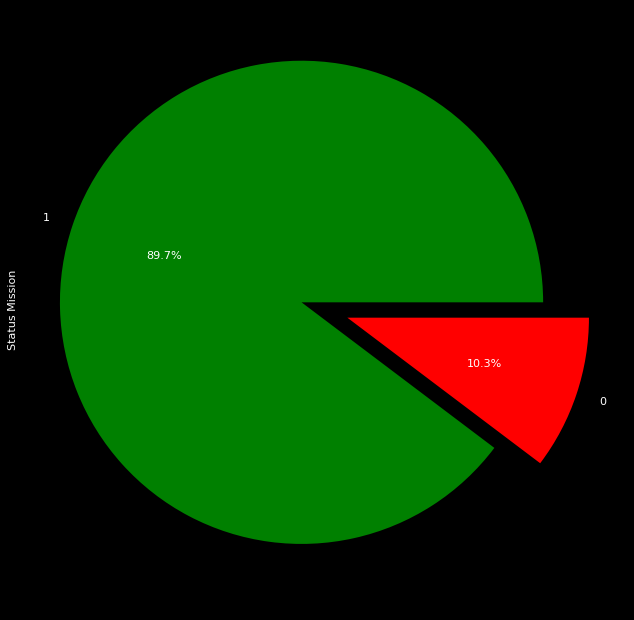

In [54]:
# success and failure persentage 
colors=['green', 'red']
space['Status Mission'].value_counts().plot.pie(explode=(0.1, 0.1),
                                                autopct='%1.1f%%',figsize=(10,10), colors=colors);

In [18]:
space.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4324 entries, 2020 to 1957
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   Company Name    4324 non-null   object             
 1   Location        4324 non-null   object             
 2   Datum           4324 non-null   datetime64[ns, UTC]
 3   Detail          4324 non-null   object             
 4   Status Rocket   4324 non-null   object             
 5   Status Mission  4324 non-null   int64              
 6   Launch Site     4324 non-null   object             
 7   Country         4324 non-null   object             
 8   Mission Month   4324 non-null   int64              
 9   Mission Day     4324 non-null   int64              
dtypes: datetime64[ns, UTC](1), int64(3), object(6)
memory usage: 371.6+ KB


# Baseline


In [19]:
# baseline

print('Baseline Accuracy:', space['Status Mission'].value_counts(normalize=True).max())

Baseline Accuracy: 0.8970860314523589


In [20]:
space.index.unique()

Int64Index([2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010,
            2009, 2008, 2007, 2006, 2005, 2004, 2003, 2002, 2001, 2000, 1999,
            1998, 1997, 1996, 1995, 1994, 1993, 1992, 1991, 1990, 1989, 1988,
            1987, 1986, 1985, 1984, 1983, 1982, 1981, 1980, 1979, 1978, 1977,
            1976, 1975, 1974, 1973, 1972, 1971, 1970, 1969, 1968, 1967, 1966,
            1965, 1964, 1963, 1962, 1961, 1960, 1959, 1958, 1957],
           dtype='int64', name='Mission Year')

# Data Split


In [21]:
# im gonna do the split at 2017 

train = space[space.index < 2017]
test = space[space.index >= 2017]
print(train.shape)
print(test.shape)

(3943, 10)
(381, 10)


In [22]:
train['Status Mission'].unique()

array([0, 1])

In [23]:
target = 'Status Mission'

y = train[target]
X = train.drop([target,'Datum'], axis=1)

In [24]:
# lets do a random split for train dataset

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((3154, 8), (789, 8), (3154,), (789,))

In [26]:
# baseline 

print('Baseline: ', y_train.value_counts(normalize=True).max())

Baseline:  0.8928344958782498


# Logistic regression

In [27]:
# Make pipeline!
logistic_reg = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(),
    LogisticRegression())

In [28]:
# Fit on train, score on val
logistic_reg.fit(X_train, y_train)
y_pred = logistic_reg.predict(X_val)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [29]:
print('Training Accuracy: ', logistic_reg.score(X_train, y_train))
print('Validation Accuracy: ', logistic_reg.score(X_val, y_val))


Training Accuracy:  0.9067850348763475
Validation Accuracy:  0.9024081115335868


In [30]:
y_test = test[target]
X_test = test.drop([target, 'Datum'], axis=1)

In [63]:
print('Test Accuracy Score: ', logistic_reg.score(X_test, y_test))

Test Accuracy Score:  0.9291338582677166


In [32]:
y_test.value_counts()

1    354
0     27
Name: Status Mission, dtype: int64

In [35]:
logistic_reg.predict(status)

array([1])

In [36]:
print(classification_report(y_val, logistic_reg.predict(X_val)))

              precision    recall  f1-score   support

           0       0.67      0.07      0.13        80
           1       0.91      1.00      0.95       709

    accuracy                           0.90       789
   macro avg       0.79      0.54      0.54       789
weighted avg       0.88      0.90      0.87       789



# Randoom Forest


In [59]:
random_forset = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier()
) 

In [60]:
random_forset.fit(X_train, y_train)
y_pred = random_forset.predict(X_val)

In [61]:
print('Training Accuracy: ', random_forset.score(X_train, y_train))
print('Validation Accuracy: ', random_forset.score(X_val, y_val))


Training Accuracy:  1.0
Validation Accuracy:  0.8935361216730038


In [64]:
print('Test Accuracy: ', random_forset.score(X_test, y_test))

Test Accuracy:  0.9343832020997376


In [41]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 80

Detail           0.308748
Mission Day      0.213978
Mission Month    0.147516
Location         0.144673
Company Name     0.072859
Launch Site      0.059612
Country          0.037952
Status Rocket    0.014661
dtype: float64


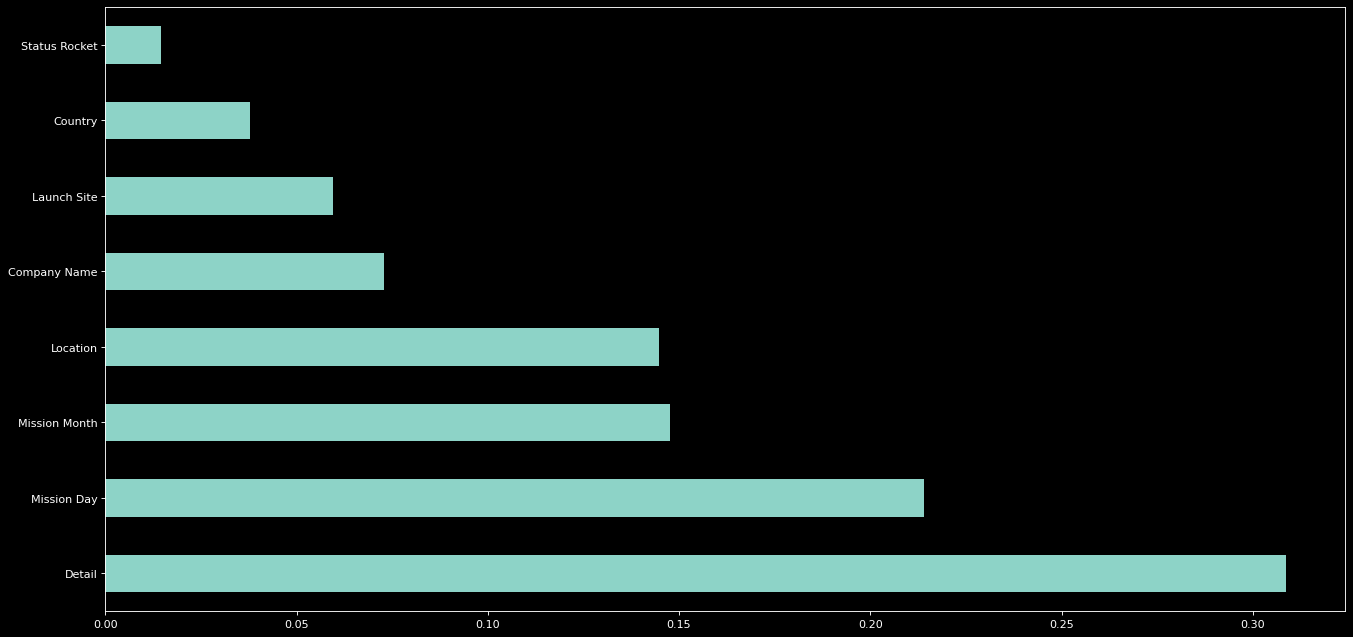

In [65]:
fi = random_forset.named_steps['randomforestclassifier'].feature_importances_
importances = pd.Series(fi, X_train.columns).sort_values(ascending=False)
print(importances)
importances.plot(kind='barh');

In [44]:
print(classification_report(y_val, random_forset.predict(X_val)))

              precision    recall  f1-score   support

           0       0.42      0.10      0.16        80
           1       0.91      0.98      0.94       709

    accuracy                           0.89       789
   macro avg       0.66      0.54      0.55       789
weighted avg       0.86      0.89      0.86       789



In [74]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


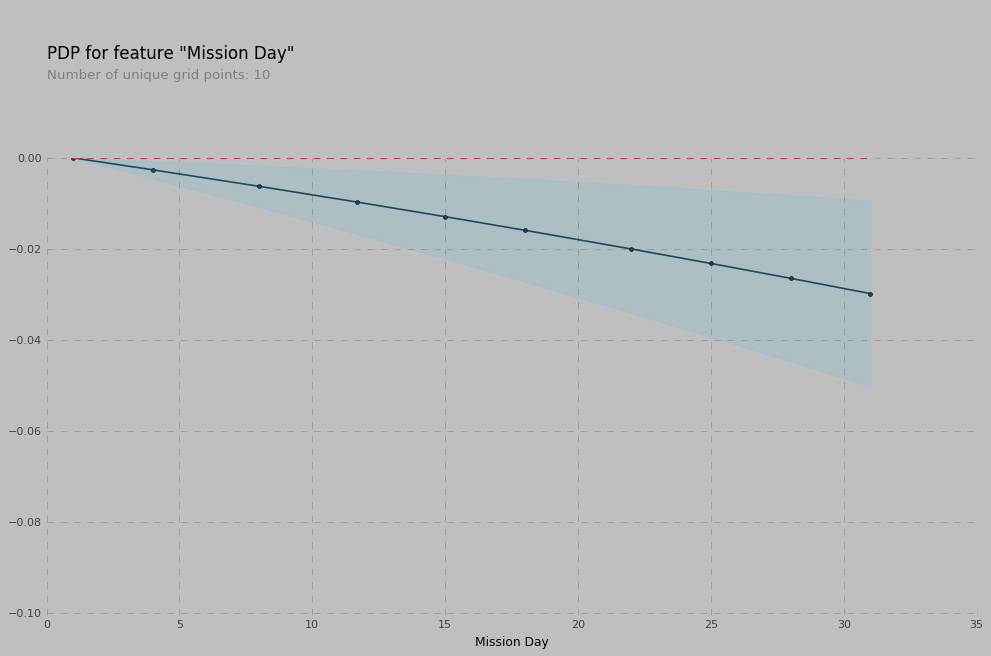

In [79]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot
from pdpbox.pdp import pdp_isolate, pdp_plot
plt.style.use('seaborn-bright')
feature = 'Mission Day'

isolated = pdp_isolate(
    model=logistic_reg,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

In [47]:
status = X_train.iloc[[750]]
status

,Company Name,Location,Detail,Status Rocket,Launch Site,Country,Mission Month,Mission Day
Mission Year,,,,,,,,
1976,RVSN USSR,"Site 132/1, Plesetsk Cosmodrome, Russia",Cosmos-3M (11K65M) | Cosmos 807,StatusRetired,Plesetsk Cosmodrome,Russia,3,12


In [48]:
random_forset.predict(status)

array([1])

In [50]:
logistic_reg.predict(status)

array([1])